In [ ]:
## Quantamental ##  

# https://www.aaii.com/sentimentsurvey
# https://production.dataviz.cnn.io/index/fearandgreed/graphdata
# https://nefin.com.br/data/volatility_index.html
# https://www.spglobal.com/spdji/pt/indices/indicators/sp-b3-ibovespa-vix/#overview
# https://www.spglobal.com/spdji/pt/documents/methodologies/methodology-sp-b3-ibovespa-vix-portuguese.pdf

# Riskofolio, QuantConnect

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import warnings

warnings.filterwarnings('ignore')

tickers = ['PETR4.SA', 'BBAS3.SA', 'ITUB4.SA']

start = dt.datetime(2021, 1, 1)
end = dt.datetime.today()

df = yf.download(tickers, start=start, end=end)['Adj Close']

[*********************100%%**********************]  3 of 3 completed


In [59]:
import talib

def calculate_rsi(data, period=14):
    rsi = talib.RSI(data, timeperiod=period)
    return rsi

data_rsi = pd.DataFrame()
for ticker in tickers:
    data_rsi[f'{ticker}_rsi'] = calculate_rsi(df[ticker])

df_rsi = df.join(data_rsi).dropna()

In [60]:
vix = pd.read_excel('PerformanceGraphExport.xls', sheet_name='Performance Graph', skiprows=6).dropna()
vix.iloc[:, 0] = pd.to_datetime(vix.iloc[:, 0])
vix.columns = ['Date', 'VIX']
vix = vix.set_index('Date')


df_rsi_vix = pd.merge_ordered(df_rsi, vix, on='Date', how='left', fill_method='ffill')
df_rsi_vix = df_rsi_vix.dropna()

In [61]:
lower_vix, upper_vix = np.quantile(df_rsi_vix['VIX'], [0.25, 0.75])

In [62]:
sentiment = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
scores = [0, 25, 45, 55, 75, 100]

In [63]:
df_rsi_vix['mean_rsi'] = df_rsi_vix[[f'{ticker}_rsi' for ticker in tickers]].mean(axis=1)
df_rsi_vix['INDEX'] = df_rsi_vix[['mean_rsi', 'VIX']].mean(axis=1)

lim_1, lim_2 = df_rsi_vix['INDEX'].quantile([0.25, 0.75])

df_rsi_vix['signal'] = np.where((df_rsi_vix['INDEX'] > lim_2) | (df_rsi_vix['INDEX'] < lim_1), 1, 0)

In [64]:
import riskfolio as rp

rebalance_dates = df_rsi_vix[df_rsi_vix['signal'] == 1]['Date'].to_frame()
rebalance_dates[tickers] = 0

further_date = rebalance_dates['Date'].min()
recent_date = rebalance_dates['Date'].max()
start_date = further_date - dt.timedelta(days=365 * 2)

df_train = yf.download(tickers, start=start_date, end=recent_date)['Adj Close']
Y = df_train.pct_change().dropna()

def calculate_weights(date, Y):
    Y_train = Y.loc[:date]
    port = rp.Portfolio(returns=Y_train)
    port.assets_stats(method_mu='hist', method_cov='hist')
    w = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=0, hist=True)
    return w

for date in rebalance_dates['Date']:
    w = calculate_weights(date, Y)
    rebalance_dates.loc[rebalance_dates['Date'] == date, w.T.columns] = w.T.iloc[0].to_list()

[*********************100%%**********************]  3 of 3 completed


In [65]:
rebalance_dates.set_index('Date', inplace=True)

In [66]:
import bt

# Buy and Hold
bt_strategy = bt.Strategy('Buy and Hold', [bt.algos.RunOnce(), 
                                           bt.algos.SelectAll(), 
                                           bt.algos.WeighEqually(), 
                                           bt.algos.Rebalance()])
# Daily Rebalance
bt_strategy_daily = bt.Strategy('Daily Rebalance', [bt.algos.RunDaily(), 
                                                    bt.algos.SelectAll(), 
                                                    bt.algos.WeighEqually(), 
                                                    bt.algos.Rebalance()])

# Weekly Rebalance
bt_strategy_weekly = bt.Strategy('Weekly Rebalance', [bt.algos.RunWeekly(), 
                                                      bt.algos.SelectAll(), 
                                                      bt.algos.WeighEqually(), 
                                                      bt.algos.Rebalance()])
# Monthly Rebalance
bt_strategy_monthly = bt.Strategy('Monthly Rebalance', [bt.algos.RunMonthly(), 
                                                        bt.algos.SelectAll(), 
                                                        bt.algos.WeighEqually(), 
                                                        bt.algos.Rebalance()])

In [67]:
rebalance_dates_copy = rebalance_dates.copy()
rebalance_dates_copy[tickers] = np.random.dirichlet(np.ones(len(tickers)), size=len(rebalance_dates))

100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


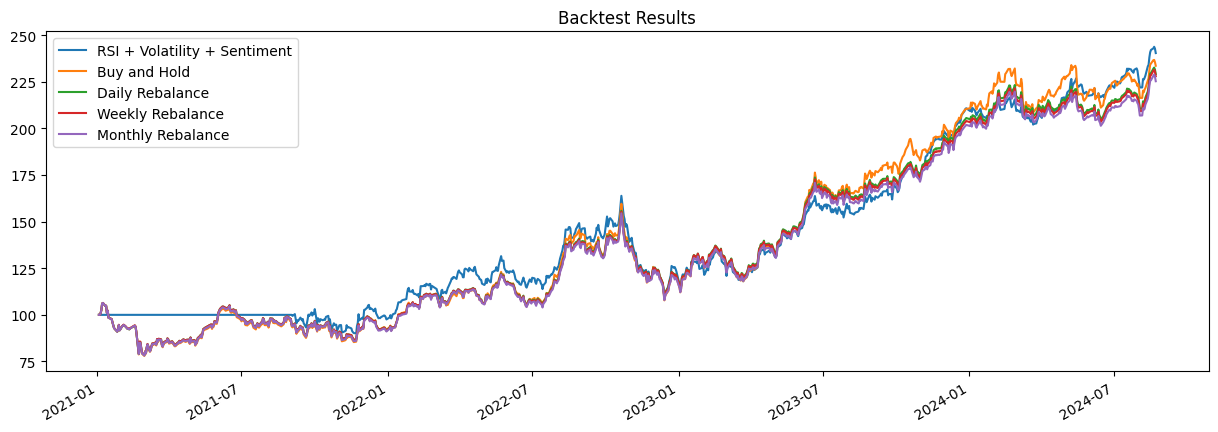

In [74]:
# RSI + Volatility + Sentiment
bt_strategy_rsi_vol_sent = bt.Strategy('RSI + Volatility + Sentiment', [bt.algos.WeighTarget(rebalance_dates_copy),
                                                                         bt.algos.Rebalance()])

bt_buynhold = bt.Backtest(bt_strategy, df, initial_capital=1000)
bt_daily = bt.Backtest(bt_strategy_daily, df, initial_capital=1000)
bt_weekly = bt.Backtest(bt_strategy_weekly, df, initial_capital=1000)
bt_monthly = bt.Backtest(bt_strategy_monthly, df, initial_capital=1000)
bt_rsi_vol_sent = bt.Backtest(bt_strategy_rsi_vol_sent, df, initial_capital=1000)

bt_results = bt.run(bt_rsi_vol_sent, bt_buynhold, bt_daily, bt_weekly, bt_monthly)
bt_results.plot(title='Backtest Results')
plt.show()

In [75]:
bt_results.display()

Stat                 RSI + Volatility + Sentiment    Buy and Hold    Daily Rebalance    Weekly Rebalance    Monthly Rebalance
-------------------  ------------------------------  --------------  -----------------  ------------------  -------------------
Start                2021-01-03                      2021-01-03      2021-01-03         2021-01-03          2021-01-03
End                  2024-08-22                      2024-08-22      2024-08-22         2024-08-22          2024-08-22
Risk-free rate       0.00%                           0.00%           0.00%              0.00%               0.00%

Total Return         140.34%                         133.55%         129.11%            127.96%             125.24%
Daily Sharpe         1.21                            1.04            1.06               1.06                1.04
Daily Sortino        1.98                            1.65            1.70               1.69                1.67
CAGR                 27.30%                        

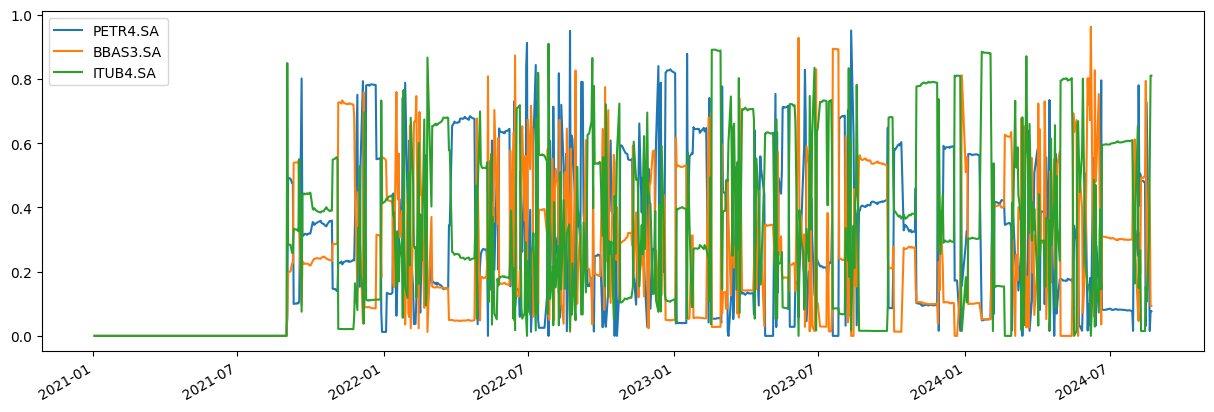

In [76]:
bt_results.plot_security_weights()

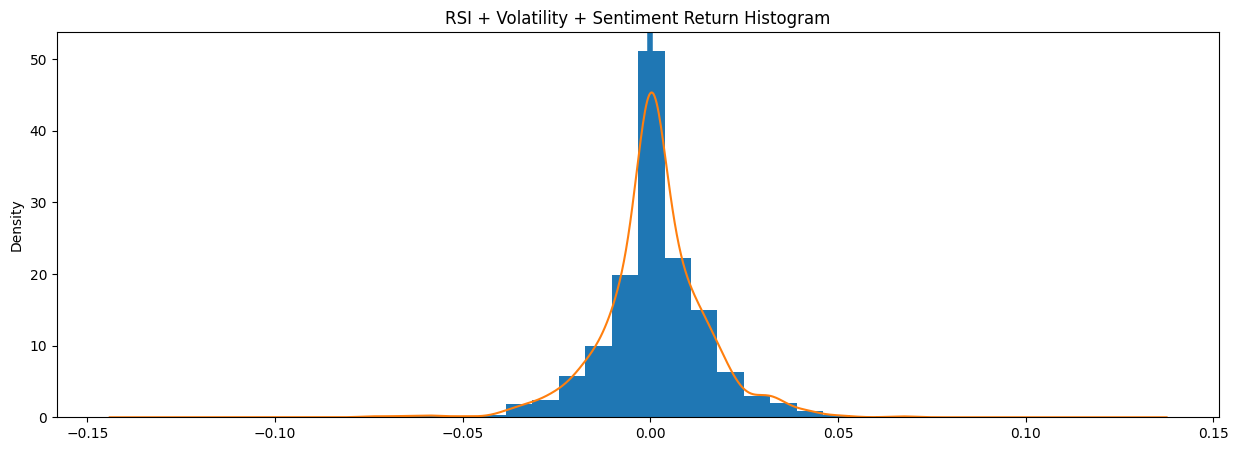

In [77]:
bt_results.plot_histogram()

In [72]:
bt_results.display_lookback_returns()

,RSI + Volatility + Sentiment,Buy and Hold,Daily Rebalance,Weekly Rebalance,Monthly Rebalance
mtd,5.57%,4.52%,5.84%,5.79%,5.82%
3m,8.73%,7.19%,8.72%,8.70%,8.51%
6m,12.43%,1.86%,3.97%,4.12%,3.89%
ytd,14.01%,11.18%,11.85%,11.96%,11.80%
1y,51.26%,37.60%,38.83%,38.51%,38.41%
3y,34.83%,35.48%,34.30%,34.04%,33.68%
5y,nan%,nan%,nan%,nan%,nan%
10y,nan%,nan%,nan%,nan%,nan%
incep,27.97%,26.63%,25.94%,25.81%,25.28%


In [89]:
bt_results.get_transactions()

price  quantity
Date       Security                     
2021-09-02 BBAS3.SA  11.652180       6.0
           ITUB4.SA  25.730776      33.0
           PETR4.SA  10.079450       6.0
2021-09-03 BBAS3.SA  11.624243      11.0
           ITUB4.SA  25.584677     -22.0
...                        ...       ...
2024-08-20 ITUB4.SA  37.230000      18.0
           PETR4.SA  37.230434     -13.0
2024-08-21 BBAS3.SA  28.658503     -25.0
           ITUB4.SA  37.080002      16.0
           PETR4.SA  37.006802       4.0

[1096 rows x 2 columns]